In [1]:
# Importar las bibliotecas
import pandas as pd
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')
# Ruta donde se guardará el archivo en Google Drive
ruta_archivo = '/content/drive/My Drive/Tesis/data/data.xlsx'

Mounted at /content/drive


In [71]:
## Bibliotecas estándar
import re
import numpy as np
import pandas as pd

## Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit-learn: Preprocesamiento
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

## Scikit-learn: Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Scikit-learn: Métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

## TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

## Widgets interactivos
from ipywidgets import Dropdown, interact

## **PREPROCESAMIENTO DE LA DATA**

In [72]:
# Cargar el archivo Excel
df = pd.read_excel(ruta_archivo)

# Diccionarios de datos
estadio_alturas = {
    'Estadio Banco Guayaquil': 2518,
    'Estadio Rodrigo Paz Delgado': 2726,
    'Estadio Monumental Isidro Romero Carbo': 9,
    'Estadio Olímpico Atahualpa': 2783,
    'Estadio 9 de Mayo': 5,
    'Estadio Federativo Reina del Cisne': 2072,
    'Estadio Jocay': 34,
    'Estadio Olímpico de Ibarra': 2200,
    'Estadio Bellavista de Ambato': 2617,
    'Estadio Gonzalo Pozo Ripalda': 2867,
    'Estadio del Mushuc Runa Sporting Club': 3252,
    'Estadio George Capwell': 3,
    'Estadio Alejandro Serrano Aguilar': 2523,
    'Estadio Municipal La Cocha': 2778,
    'Estadio Christian Benítez Betancourt': 4,
    'Estadio Municipal Jorge Andrade Cantos': 2514,
    'Estadio Gerardo León Pozo': 2296,
    'Estadio Modelo Alberto Spencer': 11,
    'Estadio Olímpico de Riobamba': 2771,
    'Estadio General Rumiñahui del Valle': 2500,
    'Estadio Reales Tamarindos': 53
}

Equipos_sin_altura = [
    '9 de Octubre FC', 'Barcelona SC', 'CS Emelec', 'Delfin SC', 'Fuerza Amarilla SC',
    'Guayaquil City FC', 'LDU Portoviejo', 'Manta FC', 'Orense SC'
]

Equipos_con_altura = [
    'CD Independiente del Valle', 'LDU de Quito', 'CD El Nacional', 'Libertad FC',
    'Imbabura SC', 'CD Macara', 'SD Aucas', 'Mushuc Runa SC', 'CD Universidad Catolica',
    'Cumbaya FC', 'CD Tecnico Universitario', 'CD Cuenca', 'Gualaceo SC', 'CD Olmedo',
    'CD America Quito'
]

Altura_por_equipo = {
    '9 de Octubre FC': 11, 'Barcelona SC': 9, 'CD America Quito': 2783,
    'CD Cuenca': 2523, 'CD El Nacional': 2783, 'CD Independiente del Valle': 2518,
    'CD Macara': 2617, 'CD Olmedo': 2771, 'CD Tecnico Universitario': 2617,
    'CD Universidad Catolica': 2783, 'CS Emelec': 3, 'Cumbaya FC': 2783,
    'Delfin SC': 34, 'Fuerza Amarilla SC': 5, 'Gualaceo SC': 2296,
    'Guayaquil City FC': 4, 'Imbabura SC': 2200, 'LDU de Quito': 2726,
    'LDU Portoviejo': 53, 'Libertad FC': 2072, 'Manta FC': 34,
    'Mushuc Runa SC': 3252, 'Orense SC': 5, 'SD Aucas': 2867
}

# Preprocesamiento de datos
df['Estadio'] = df['Estadio'].replace(estadio_alturas)
df = df.rename(columns={'Estadio': 'Altura'})

df['Saldo_Goles'] = df['GF'] - df['GC']
df['diferencia_altitud'] = df['Altura'] - df['Adversario'].map(Altura_por_equipo)

# Escalar probabilidades
df['P. Victoria'] = 1 / df['P. Victoria'].astype(float)
df['P. Empate'] = 1 / df['P. Empate'].astype(float)
df['P. Perdida'] = 1 / df['P. Perdida'].astype(float)

# Codificación One-Hot para formaciones
encoder = OneHotEncoder(sparse_output=False)
prefijo_vst = 'vst_'
prefijo_lcl = 'lcl_'

formaciones_oponente_encoded = encoder.fit_transform(df[['Formación del oponente']])
formaciones_oponente_df = pd.DataFrame(formaciones_oponente_encoded, columns=[f"{prefijo_vst}{categoria}" for categoria in encoder.categories_[0]])

formaciones_encoded = encoder.fit_transform(df[['Formación']])
formaciones_df = pd.DataFrame(formaciones_encoded, columns=[f"{prefijo_lcl}{categoria}" for categoria in encoder.categories_[0]])

df = pd.concat([df, formaciones_oponente_df, formaciones_df], axis=1)

# Clasificación de partidos
def clasificar_partido(row):
    local_en_altura = row['Equipo'] in Equipos_con_altura
    visitante_en_altura = row['Adversario'] in Equipos_con_altura
    local_en_costa = row['Equipo'] in Equipos_sin_altura
    visitante_en_costa = row['Adversario'] in Equipos_sin_altura

    if local_en_altura and visitante_en_altura:
        return 'Altura vs Altura'
    elif local_en_costa and visitante_en_costa:
        return 'Costa vs Costa'
    elif local_en_altura and visitante_en_costa:
        return 'Altura vs Costa'
    elif local_en_costa and visitante_en_altura:
        return 'Costa vs Altura'

df['clasificacion_del_partido'] = df.apply(clasificar_partido, axis=1)

# Filtrar DataFrames por clasificación de partidos
df_sierra_costa = df[df['clasificacion_del_partido'] == 'Altura vs Costa']
df_costa_sierra = df[df['clasificacion_del_partido'] == 'Costa vs Altura']
df_sierra_sierra = df[df['clasificacion_del_partido'] == 'Altura vs Altura']
df_costa_costa = df[df['clasificacion_del_partido'] == 'Costa vs Costa']

# Escalado de variables continuas
scaler = MinMaxScaler()
df[['diferencia_altitud', 'Saldo_Goles', 'Altura']] = scaler.fit_transform(df[['diferencia_altitud', 'Saldo_Goles', 'Altura']])

<ipython-input-72-e6930f3edd3f>:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Estadio'] = df['Estadio'].replace(estadio_alturas)


## **EQUIPO A EVALUAR**

In [41]:
# Lista de opciones
equipos = ['Barcelona SC', 'CS Emelec', 'Delfin SC', 'Orense SC']

# Crear un widget de lista desplegable
dropdown = Dropdown(
    options=equipos,
    value='Barcelona SC',  # Valor predeterminado
    description='Equipo:',
)

# Variable para almacenar el valor seleccionado
Equipos_evaluar = dropdown.value

# Función para actualizar la variable y mostrar el valor seleccionado
def seleccionar_equipo(equipo):
    global Equipos_evaluar
    Equipos_evaluar = equipo


# Vincular el widget con la función
interact(seleccionar_equipo, equipo=dropdown)

interactive(children=(Dropdown(description='Equipo:', options=('Barcelona SC', 'CS Emelec', 'Delfin SC', 'Oren…

<function __main__.seleccionar_equipo(equipo)>

## **MODELO DE RED NEURONAL MLP**

In [42]:

# Configuracion Inicial
data_evaluar = df.copy()
modelo = "MLP"

# Configuración del modelo y variables
y_variables = [
    "vst_3-1-4-2", "vst_3-3-3-1", "vst_3-4-1-2", "vst_3-4-2-1", "vst_3-4-3",
    "vst_3-5-1-1", "vst_3-5-2", "vst_4-1-3-2", "vst_4-1-4-1", "vst_4-2-2-2",
    "vst_4-2-3-1", "vst_4-3-1-2", "vst_4-3-2-1", "vst_4-3-3", "vst_4-4-1-1",
    "vst_4-4-2", "vst_4-5-1", "vst_5-3-2", "vst_5-4-1"
]
x_variables = [
    "P. Victoria", "P. Empate", "P. Perdida", "diferencia_altitud", "Altura"
]

# Filtrar datos para evaluación, prueba y entrenamiento
val_data = data_evaluar[
    (data_evaluar['Fecha'].dt.year == 2024) &
    (data_evaluar['clasificacion_del_partido'] == 'Altura vs Costa') &
    (data_evaluar['Adversario'] == Equipos_evaluar)
]
test_data = data_evaluar[
    (data_evaluar['Fecha'].dt.year == 2024) &
    ((data_evaluar['Resultado'] == 'D') | (data_evaluar['Resultado'] == 'E'))
]
train_data = data_evaluar[
    (data_evaluar['Fecha'].dt.year != 2024) &
    ((data_evaluar['Resultado'] == 'D') | (data_evaluar['Resultado'] == 'E'))
]

# Separar características y etiquetas
X_train = train_data[x_variables]  # Características de entrenamiento
y_train = train_data[y_variables]  # Etiquetas de entrenamiento

X_test = test_data[x_variables]    # Características de prueba
y_test = test_data[y_variables]    # Etiquetas de prueba

# Función de pérdida ponderada
def weighted_loss(y_true, y_pred):
    # Convertir 'y_true' a formato One-Hot
    y_true_one_hot = tf.one_hot(tf.argmax(y_true, axis=1), depth=y_pred.shape[1])

    # Obtener los índices de los datos del batch actual
    batch_indices = tf.range(tf.shape(y_true)[0])

    # Obtener los valores de 'resultado' para el batch actual
    resultado_batch = tf.gather(df['Resultado'].values, batch_indices)

    # Crear pesos para la pérdida
    weights = tf.where(resultado_batch == 'V', 10.0,
                       tf.where(resultado_batch == 'E', 2.0, 0.0))

    # Calcular la pérdida ponderada
    loss = tf.reduce_mean(tf.losses.categorical_crossentropy(y_true_one_hot, y_pred) * weights)
    return loss

# Crear el modelo de red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')  # Salida con softmax
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Realizar predicciones
predictions = model.predict(val_data[x_variables])
clases = [s.lstrip('vst_') for s in y_variables]
predicted_classes = predictions.argmax(axis=1)
predicted_true = np.argmax(val_data[y_variables].values, axis=1)

predicted_classes = [clases[pos] for pos in predicted_classes]
predicted_true = [clases[pos] for pos in predicted_true]

# Calcular métricas
accuracy = accuracy_score(predicted_true, predicted_classes)
recall = recall_score(predicted_true, predicted_classes, average='weighted')
precision = precision_score(predicted_true, predicted_classes, average='weighted')
f1_score = 2 * (precision * recall) / (precision + recall)

# Imprimir métricas
print(f"Precisión: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precisión: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(classification_report(predicted_true, predicted_classes))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1024 - loss: 2.9103 - val_accuracy: 0.3876 - val_loss: 2.7588
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3535 - loss: 2.7155 - val_accuracy: 0.3876 - val_loss: 2.4442
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3724 - loss: 2.4086 - val_accuracy: 0.3876 - val_loss: 2.1175
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3861 - loss: 2.1162 - val_accuracy: 0.3876 - val_loss: 1.9496
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3775 - loss: 2.0066 - val_accuracy: 0.3876 - val_loss: 1.8686
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3882 - loss: 1.9090 - val_accuracy: 0.3876 - val_loss: 1.8519
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3925 - loss: 1.8815 - val_accuracy: 0.3876 - val_loss: 1.8505
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3735 - loss: 1.8954 - val_accuracy: 0.3876 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


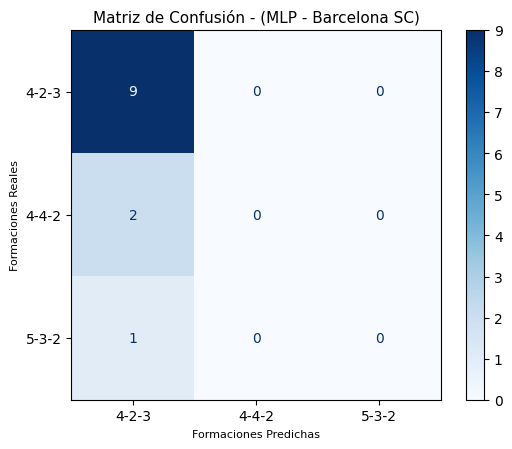

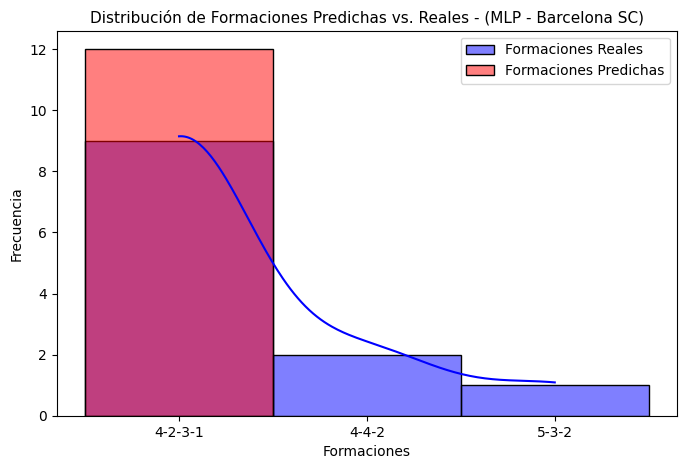

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


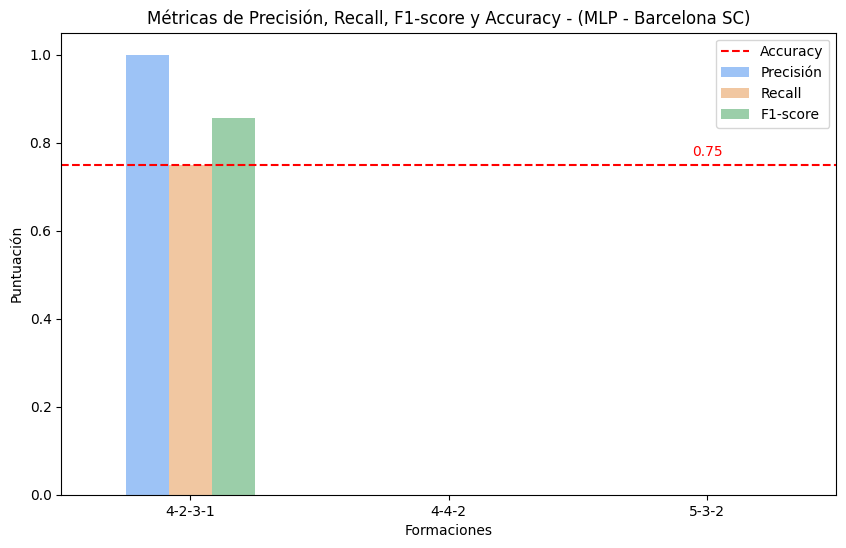

In [43]:
# Generar el reporte de clasificación
report_string = classification_report(predicted_true, predicted_classes)

# Extraer las etiquetas de las formaciones usando una expresión regular
labels = re.findall(r'^\s*(\d+-\d+-\d+|\d+-\d+)', report_string, re.MULTILINE)

# Si no se encuentran etiquetas, usar los valores únicos de predicted_true y predicted_classes
if not labels:
    labels = sorted(list(set(predicted_true) | set(predicted_classes)))

# Calcular la matriz de confusión
cm = confusion_matrix(predicted_true, predicted_classes)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

# Personalizar la visualización
plt.xlabel("Formaciones Predichas", fontsize=8)
plt.ylabel("Formaciones Reales", fontsize=8)
plt.title(f"Matriz de Confusión - ({modelo} - {Equipos_evaluar})", fontsize=11)

# Mostrar la gráfica
plt.show()

# Graficar la distribución de formaciones predichas vs. reales
plt.figure(figsize=(8, 5))
sns.histplot(predicted_true, color="blue", label="Formaciones Reales", kde=True, alpha=0.5)
sns.histplot(predicted_classes, color="red", label="Formaciones Predichas", kde=True, alpha=0.5)
plt.xlabel("Formaciones")
plt.ylabel("Frecuencia")
plt.legend()
plt.title(f"Distribución de Formaciones Predichas vs. Reales - ({modelo} - {Equipos_evaluar})", fontsize=11)
plt.show()

# Generar el reporte de clasificación en formato de diccionario
report = classification_report(predicted_classes, predicted_true, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-3, :]  # Excluir promedios y accuracy

# Extraer el accuracy
accuracy = report["accuracy"]

# Graficar métricas por clase con colores personalizados
colores_personalizados = ['#85b5f4', '#eeba8a', '#82c294']  # Azul, Naranja, Verde
df_report[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(10, 6),
    color=colores_personalizados,  # Colores personalizados
    alpha=0.8
)

# Agregar el accuracy como una línea horizontal
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Accuracy: {accuracy:.2f}')

# Agregar el valor del accuracy sobre la línea roja
plt.text(
    x=len(df_report) - 1,  # Posición en el eje x (última barra)
    y=accuracy + 0.02,     # Posición en el eje y (ligeramente por encima de la línea roja)
    s=f'{accuracy:.2f}',   # Texto a mostrar
    color='red',           # Color del texto
    fontsize=10,           # Tamaño de la fuente
    ha='center'            # Alineación horizontal
)

# Personalizar el gráfico
plt.xlabel("Formaciones")
plt.ylabel("Puntuación")
plt.title(f"Métricas de Precisión, Recall, F1-score y Accuracy - ({modelo} - {Equipos_evaluar})")
plt.legend(["Accuracy", "Precisión", "Recall", "F1-score"])
plt.xticks(rotation=0)
plt.show()

-----------------------------------------------------------------
Predicciones en Victoria: 3 de 4 = 9 puntos
Predicciones en Empate: 3 de 3 = 3 puntos
Predicciones en Derrota: 3 de 5 = 0 puntos
-----------------------------------------------------------------

Resultados para el Partido 1:
Formación real del partido: 4-2-3-1
Formación: 4-2-3-1, Probabilidad: 44.13999938964844%
Formación: 4-4-2, Probabilidad: 28.610000610351562%
Formación: 4-3-3, Probabilidad: 10.319999694824219%
Formación: 3-4-3, Probabilidad: 3.440000057220459%
Formación: 4-1-4-1, Probabilidad: 3.049999952316284%
Formación: 4-4-1-1, Probabilidad: 2.6500000953674316%
Formación: 3-5-2, Probabilidad: 1.7799999713897705%
Formación: 5-3-2, Probabilidad: 1.3300000429153442%
Formación: 5-4-1, Probabilidad: 0.9700000286102295%
Formación: 3-1-4-2, Probabilidad: 0.8399999737739563%
Formación: 4-5-1, Probabilidad: 0.7699999809265137%
Formación: 4-2-2-2, Probabilidad: 0.75%
Formación: 4-3-1-2, Probabilidad: 0.7099999785423279%
F

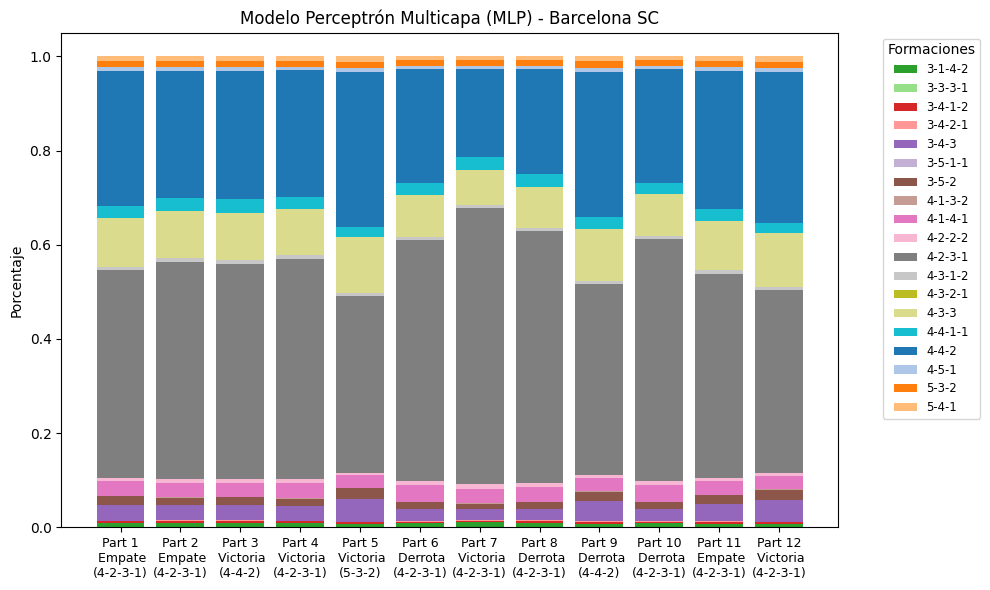

In [44]:
# Inicialización de variables
all_results = []
puntos_victoria = 0
puntos_empate = 0
puntos_derrota = 0
contador_victoria = 0
contador_empate = 0
contador_derrota = 0

# Procesar predicciones y resultados
for i, row in enumerate(predictions):
    row_results = []
    for formation, prob in zip(y_variables, row):
        row_results.append((formation, round(prob * 100, 2)))  # Convertir probabilidad a porcentaje
    row_results.append((val_data['Formación del oponente'].tolist()[i], 100))
    row_results.sort(key=lambda x: x[1], reverse=True)  # Ordenar de mayor a menor

    # Contar resultados reales
    if val_data['Resultado'].tolist()[i] == 'D':
        contador_victoria += 1
    elif val_data['Resultado'].tolist()[i] == 'E':
        contador_empate += 1
    else:
        contador_derrota += 1

    # Contar predicciones correctas
    if row_results[0][0] == row_results[1][0].replace('vst_', ''):
        if val_data['Resultado'].tolist()[i] == 'D':
            puntos_victoria += 1
        elif val_data['Resultado'].tolist()[i] == 'E':
            puntos_empate += 1
        else:
            puntos_derrota += 1

    all_results.append(row_results)

# Mostrar resumen de predicciones
print("-----------------------------------------------------------------")
print(f"Predicciones en Victoria: {puntos_victoria} de {contador_victoria} = {(puntos_victoria * 3)} puntos")
print(f"Predicciones en Empate: {puntos_empate} de {contador_empate} = {(puntos_empate * 1)} puntos")
print(f"Predicciones en Derrota: {puntos_derrota} de {contador_derrota} = {(puntos_derrota * 0)} puntos")
print("-----------------------------------------------------------------")

# Mostrar resultados detallados
for i, row_results in enumerate(all_results):
    print(f"\nResultados para el Partido {i + 1}:")
    for formation, percentage in row_results:
        if percentage == 100:
            print(f"Formación real del partido: {formation}")
        else:
            formation = formation.replace('vst_', '')
            print(f"Formación: {formation}, Probabilidad: {percentage}%")

print("-----------------------------------------------------------------")

# Configuración del gráfico de barras apiladas
probabilidades = predictions
resultados = val_data['Resultado'].map({'V': 'Victoria', 'E': 'Empate', 'D': 'Derrota'}).tolist()
formaciones = val_data['Formación del oponente'].tolist()
num_muestras = len(resultados)
indices = np.arange(num_muestras)

# Paleta de colores
paleta_colores = sns.color_palette("tab20", len(clases))
paleta_colores = paleta_colores[4:] + paleta_colores[:4]  # Rotar la paleta

# Si hay más de 20 clases, combinar paletas
if len(clases) > 20:
    paleta_colores = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", len(clases) - 20)

# Crear la figura
plt.figure(figsize=(10, 6))

# Agregar barras apiladas
bottom = np.zeros(num_muestras)
for i in range(len(clases)):
    plt.bar(indices, probabilidades[:, i], label=f'{clases[i]}', bottom=bottom, color=paleta_colores[i])
    bottom += probabilidades[:, i]

# Personalizar etiquetas del eje X
etiquetas_x = [f'Part {i+1}\n {r}\n({f})' for i, (r, f) in enumerate(zip(resultados, formaciones))]
plt.xticks(indices, etiquetas_x, rotation=0, fontsize=9)

# Etiquetas y diseño
plt.ylabel('Porcentaje')
plt.title(f'Modelo Perceptrón Multicapa (MLP) - {Equipos_evaluar}')

# Leyenda
plt.legend(title='Formaciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Ajustar espaciado
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()

# Guardar y mostrar gráfico
nombre_archivo = f'MLP_{Equipos_evaluar}.png'
plt.savefig(nombre_archivo)
plt.show()

## **MODELO DE RANDOM FOREST**

In [73]:
# Configuración inicial
data_RF = df.copy()
modelo = "Random Forest"
y_variable = "Formación del oponente"
x_variables = ["P. Victoria", "P. Empate", "P. Perdida", "diferencia_altitud", "Altura"]

# Filtrar los datos
# Filtrado de datos para validación y entrenamiento
val_data = data_RF[(data_RF['Fecha'].dt.year == 2024) &
                   (data_RF['clasificacion_del_partido'] == 'Altura vs Costa') &
                   (data_RF['Adversario'] == Equipos_evaluar)]

# División en datos de prueba y entrenamiento
test_data = data_RF[data_RF['Fecha'].dt.year == 2024 & (data_RF['Resultado'] == 'D') | (data_RF['Resultado'] == 'E')]
train_data = data_RF[data_RF['Fecha'].dt.year != 2024 & (data_RF['Resultado'] == 'D') | (data_RF['Resultado'] == 'E')]

# Asignar las variables de entrada y salida
X_train = train_data[x_variables]
y_train = train_data[y_variable]

X_test = test_data[x_variables]
y_test = test_data[y_variable]

# Configurar y entrenar el modelo
rf = RandomForestClassifier(
    max_depth=10,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)
rf.fit(X_train, y_train)

# Predicción en el conjunto de validación
y_pred = rf.predict(val_data[x_variables])

# Obtener las probabilidades de cada clase
probabilities = rf.predict_proba(val_data[x_variables])
classes = rf.classes_

# Evaluar el rendimiento del modelo
print("Accuracy:", accuracy_score(val_data[y_variable], y_pred))
print("Recall:", recall_score(val_data[y_variable], y_pred, average='weighted'))
print("Precision:", precision_score(val_data[y_variable], y_pred, average='weighted'))
print("F1-score:", f1_score(val_data[y_variable], y_pred, average='weighted'))

print("Classification Report:")
print(classification_report(val_data[y_variable], y_pred))

Accuracy: 0.9166666666666666
Recall: 0.9166666666666666
Precision: 0.8611111111111112
F1-score: 0.8833333333333333
Classification Report:
              precision    recall  f1-score   support

     4-2-3-1       1.00      1.00      1.00         9
       4-4-2       0.67      1.00      0.80         2
       5-3-2       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.56      0.67      0.60        12
weighted avg       0.86      0.92      0.88        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Labels extraídos: ['4-2-3-1', '4-4-2', '5-3-2']


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


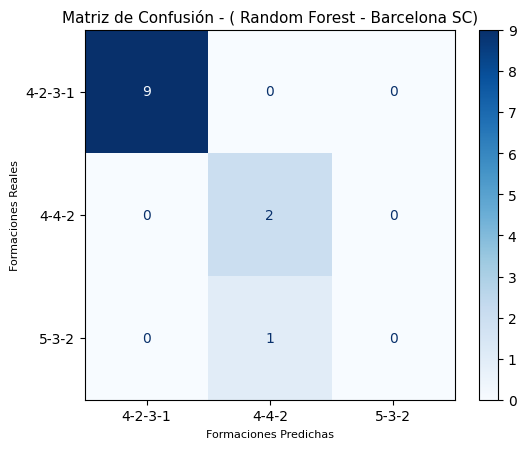

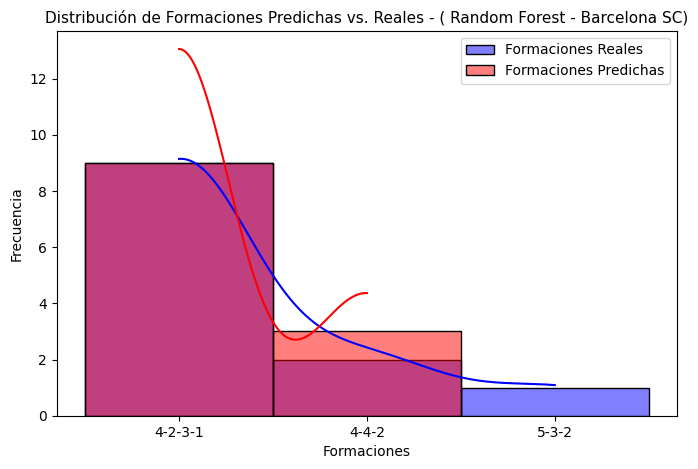

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


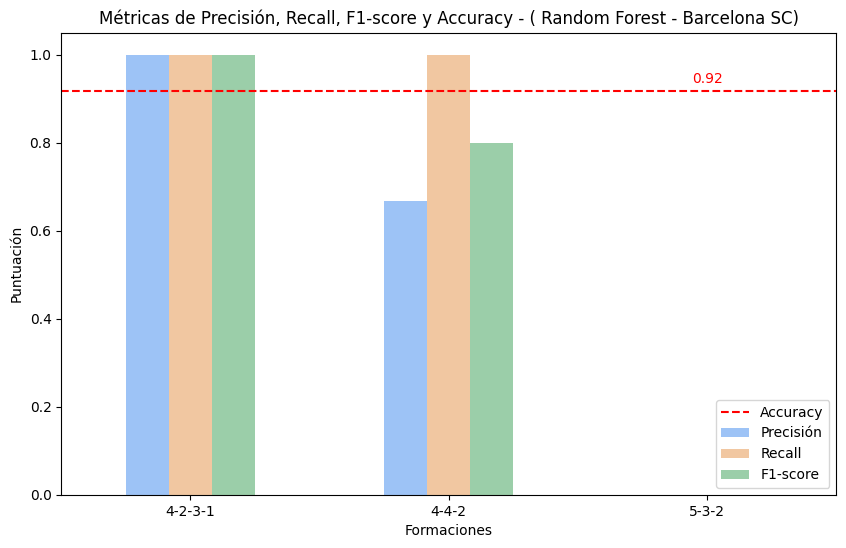

In [74]:
# Generar el reporte de clasificación
report_string = classification_report(val_data[y_variables], y_pred)
labels = re.findall(r'^\s*(\d-\d-\d-\d|\d-\d-\d)', report_string, re.MULTILINE)

print("Labels extraídos:", labels)

cm = confusion_matrix(val_data[y_variables], y_pred, labels=labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Formaciones Predichas", fontsize=8)
plt.ylabel("Formaciones Reales", fontsize=8)
plt.title(f"Matriz de Confusión - ( {modelo} - {Equipos_evaluar})", fontsize=11)
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(val_data[y_variables], color="blue", label="Formaciones Reales", kde=True, alpha=0.5)
sns.histplot(y_pred, color="red", label="Formaciones Predichas", kde=True, alpha=0.5)
plt.xlabel("Formaciones")
plt.ylabel("Frecuencia")
plt.legend()
plt.title(f"Distribución de Formaciones Predichas vs. Reales - ( {modelo} - {Equipos_evaluar})", fontsize=11)
plt.show()

report = classification_report(val_data[y_variables], y_pred, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-3, :]  # Excluir promedios y accuracy

# Extraer el accuracy
accuracy = report["accuracy"]

# Graficar métricas por clase con colores personalizados
colores_personalizados = ['#85b5f4', '#eeba8a', '#82c294']  # Azul, Naranja, Verde
df_report[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(10, 6),
    color=colores_personalizados,  # Colores personalizados
    alpha=0.8
)

# Agregar el accuracy como una línea horizontal
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Accuracy: {accuracy:.2f}')

# Agregar el valor del accuracy sobre la línea roja
plt.text(
    x=len(df_report) - 1,  # Posición en el eje x (última barra)
    y=accuracy + 0.02,     # Posición en el eje y (ligeramente por encima de la línea roja)
    s=f'{accuracy:.2f}',   # Texto a mostrar
    color='red',           # Color del texto
    fontsize=10,           # Tamaño de la fuente
    ha='center'            # Alineación horizontal
)

# Personalizar el gráfico
plt.xlabel("Formaciones")
plt.ylabel("Puntuación")
plt.title(f"Métricas de Precisión, Recall, F1-score y Accuracy - ( {modelo} - {Equipos_evaluar})")
plt.legend(["Accuracy", "Precisión", "Recall", "F1-score"])
plt.xticks(rotation=0)
#plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



-----------------------------------------------------------------
Predicciones en Victoria: 4 de 4 = 12 puntos
Predicciones en Empate: 3 de 3 = 3 puntos
Predicciones en Derrota: 4 de 5 = 0 puntos
-----------------------------------------------------------------

Resultados para el Partido 1:
Formacion real del partido: 4-2-3-1
Formación: 4-2-3-1, Probabilidad: 59.04%
Formación: 4-4-2, Probabilidad: 23.35%
Formación: 4-3-3, Probabilidad: 5.95%
Formación: 3-1-4-2, Probabilidad: 2.84%
Formación: 3-4-3, Probabilidad: 1.88%
Formación: 4-5-1, Probabilidad: 1.53%
Formación: 4-1-4-1, Probabilidad: 1.39%
Formación: 4-4-1-1, Probabilidad: 0.87%
Formación: 4-3-1-2, Probabilidad: 0.81%
Formación: 3-4-1-2, Probabilidad: 0.72%
Formación: 3-5-2, Probabilidad: 0.52%
Formación: 5-4-1, Probabilidad: 0.44%
Formación: 4-2-2-2, Probabilidad: 0.31%
Formación: 5-3-2, Probabilidad: 0.25%
Formación: 4-1-3-2, Probabilidad: 0.07%
Formación: 3-3-3-1, Probabilidad: 0.02%
Formación: 4-3-2-1, Probabilidad: 0.01%
For

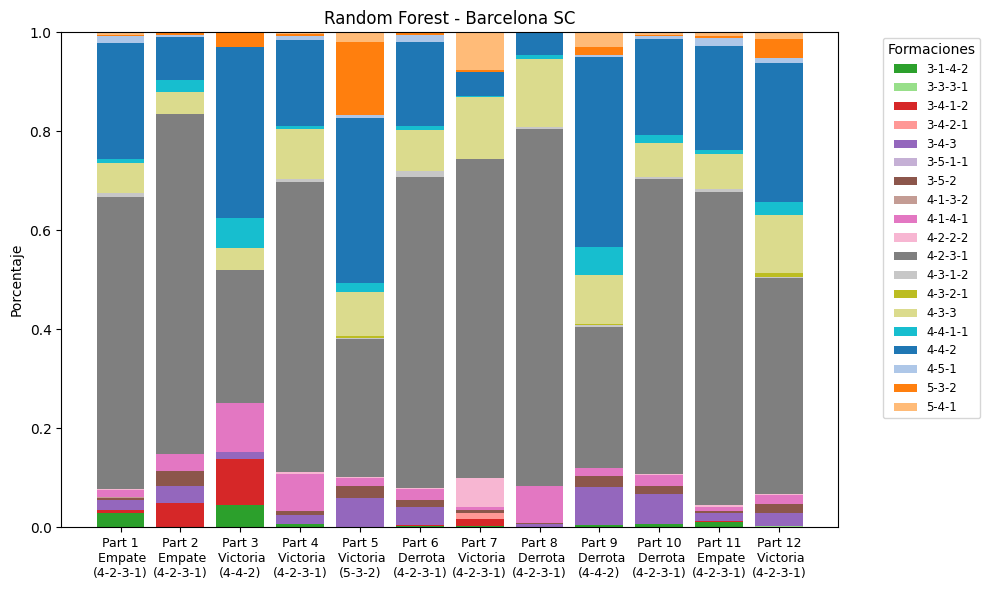

In [75]:
# Análisis de predicciones
resultados = []
for probabilidad in  probabilities:
  lista =[]
  for clase, prob in zip(classes, probabilidad):
    lista.append((clase, round(prob*100,2)))
  lista.sort(key=lambda x: x[1], reverse=True)
  resultados.append(lista)

all_results = []

# Variables de conteo
puntos_victoria = 0
puntos_empate = 0
puntos_derrota = 0
contador_victoria = 0
contador_empate = 0
contador_derrota = 0

for i, row in enumerate(resultados):
    row_results = []
    for formation, prob in row:  # Iterate through tuples in row
        row_results.append((formation, round(prob, 2)))  # Round the probability value
    row_results.append((val_data['Formación del oponente'].tolist()[i], 100))
    row_results.sort(key=lambda x: x[1], reverse=True)
    if(val_data['Resultado'].tolist()[i] == 'D'):
      contador_victoria += 1
    elif val_data['Resultado'].tolist()[i] == 'E':
      contador_empate += 1
    else:
      contador_derrota += 1

    if row_results[0][0] == row_results[1][0].replace('vst_',''):
      if val_data['Resultado'].tolist()[i] == 'D':
        puntos_victoria += 1
      elif val_data['Resultado'].tolist()[i] == 'E':
        puntos_empate += 1
      else:
        puntos_derrota += 1
    all_results.append(row_results)

print("-----------------------------------------------------------------")
print(f"Predicciones en Victoria: {puntos_victoria} de {contador_victoria} = {(puntos_victoria*3)} puntos")
print(f"Predicciones en Empate: {puntos_empate} de {contador_empate} = {(puntos_empate*1)} puntos")
print(f"Predicciones en Derrota: {puntos_derrota} de {contador_derrota} = {(puntos_derrota*0)} puntos")
print("-----------------------------------------------------------------")

# Mostrar resultados
for i, row_results in enumerate(all_results):
    print(f"\nResultados para el Partido {i + 1}:")
    for formation, percentage in row_results:
      if percentage == 100:
        print(f"Formacion real del partido: {formation}")
      else:
        formation=formation.replace('vst_','')
        print(f"Formación: {formation}, Probabilidad: {percentage}%")
print("-----------------------------------------------------------------")


clases = classes
probabilidades = probabilities

# Simulación de datos
resultados = val_data['Resultado'].map({'V': 'Victoria', 'E': 'Empate', 'D': 'Derrota'}).tolist()
formaciones = val_data['Formación del oponente'].tolist()

# Configuración del gráfico
num_muestras = len(resultados)
indices = np.arange(num_muestras)

# Paleta de colores "tab20" (20 colores distintos)
paleta_colores = sns.color_palette("tab20", len(clases))

# Rotar la paleta de colores para iniciar con un color diferente
paleta_colores = paleta_colores[4:] + paleta_colores[:4]  # Esto moverá los primeros 5 colores al final

# Si tienes más de 20 clases, puedes combinar paletas o generar colores aleatorios:
if len(clases) > 20:
    paleta_colores = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", len(clases) - 20)
    # O, para colores aleatorios:
    # paleta_colores = sns.color_palette("hls", len(clases))


# Crear la figura
plt.figure(figsize=(10, 6))

# Agregar barras apiladas
bottom = np.zeros(num_muestras)
for i in range(len(clases)):
    plt.bar(indices, probabilidades[:, i], label=f'{clases[i]}', bottom=bottom, color=paleta_colores[i])
    bottom += probabilidades[:, i]


# Personalizar etiquetas del eje X (sin cambios)
etiquetas_x = [f'Part {i+1}\n {r}\n({f})' for i, (r, f) in enumerate(zip(resultados, formaciones))]
plt.xticks(indices, etiquetas_x, rotation=0, fontsize=9)

# Etiquetas y diseño
plt.ylabel('Porcentaje')
plt.title(f'Random Forest - {Equipos_evaluar}')


# 3. Mejoras en la leyenda (opcional)
plt.legend(title='Formaciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small') # Ajusta fontsize si es necesario

# 4. Ajustar el espaciado entre barras (opcional)
plt.subplots_adjust(bottom=0.2) # Ajusta el valor según sea necesario

plt.tight_layout()
nombre_archivo = f'RF_{Equipos_evaluar}.png'
plt.savefig(nombre_archivo)

# Mostrar gráfico
plt.show()


## **MODELO DE SVM**

In [64]:
##### Configuracion Inicial #####
data_SVM = df.copy()
modelo = "SVM"

# Definición de variables dependientes e independientes
y_variables = "Formación del oponente"
x_variables = [
    "P. Victoria",
    "P. Empate",
    "P. Perdida",
    "diferencia_altitud",
    "Altura"
]

# Filtrado de datos para validación y entrenamiento
val_data = data_SVM[(data_SVM['Fecha'].dt.year == 2024) &
                   (data_SVM['clasificacion_del_partido'] == 'Altura vs Costa') &
                   (data_SVM['Adversario'] == Equipos_evaluar)]

# División en datos de prueba y entrenamiento
test_data = data_SVM[data_SVM['Fecha'].dt.year == 2024 & (data_SVM['Resultado'] == 'D') | (data_SVM['Resultado'] == 'E')]
train_data = data_SVM[data_SVM['Fecha'].dt.year != 2024 & (data_SVM['Resultado'] == 'D') | (data_SVM['Resultado'] == 'E')]

# Asignación de variables de entrada y salida
X_train = train_data[x_variables]
y_train = train_data[y_variables]
X_test = test_data[x_variables]
y_test = test_data[y_variables]

##### Entrenamiento del Modelo SVM #####
# Creación y entrenamiento del modelo SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

##### Predicción y Evaluación #####
# Predicción sobre el conjunto de validación
y_pred = svm_model.predict(val_data[x_variables])
probabilities = svm_model.predict_proba(val_data[x_variables])
classes = svm_model.classes_

# Evaluación del modelo SVM
print("Accuracy:", accuracy_score(val_data[y_variables], y_pred))
print("Recall:", recall_score(val_data[y_variables], y_pred, average='weighted'))
print("Precision:", precision_score(val_data[y_variables], y_pred, average='weighted'))
print("F1-score:", f1_score(val_data[y_variables], y_pred, average='weighted'))
print("Reporte de clasificación:")
print(classification_report(val_data[y_variables], y_pred))


Accuracy: 0.75
Recall: 0.75
Precision: 0.5625
F1-score: 0.6428571428571428
Reporte de clasificación:
              precision    recall  f1-score   support

     4-2-3-1       0.75      1.00      0.86         9
       4-4-2       0.00      0.00      0.00         2
       5-3-2       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.25      0.33      0.29        12
weighted avg       0.56      0.75      0.64        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Labels extraídos: ['4-2-3-1', '4-4-2', '5-3-2']


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


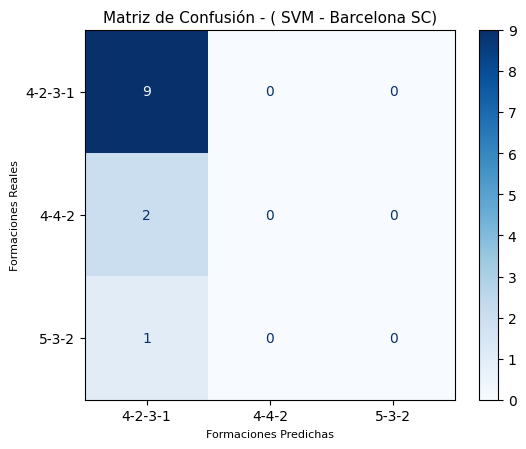

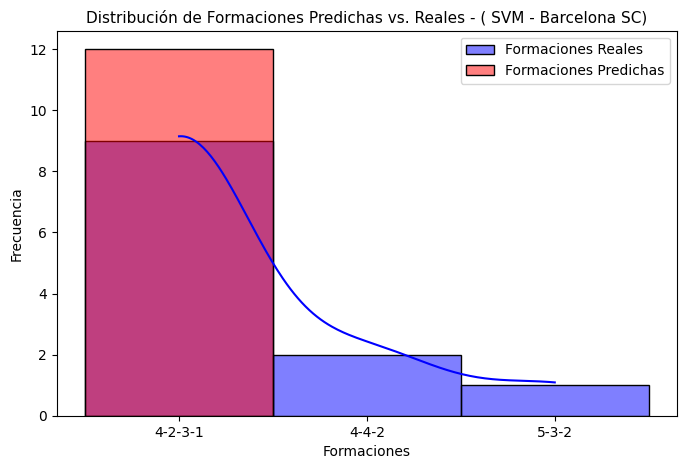

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


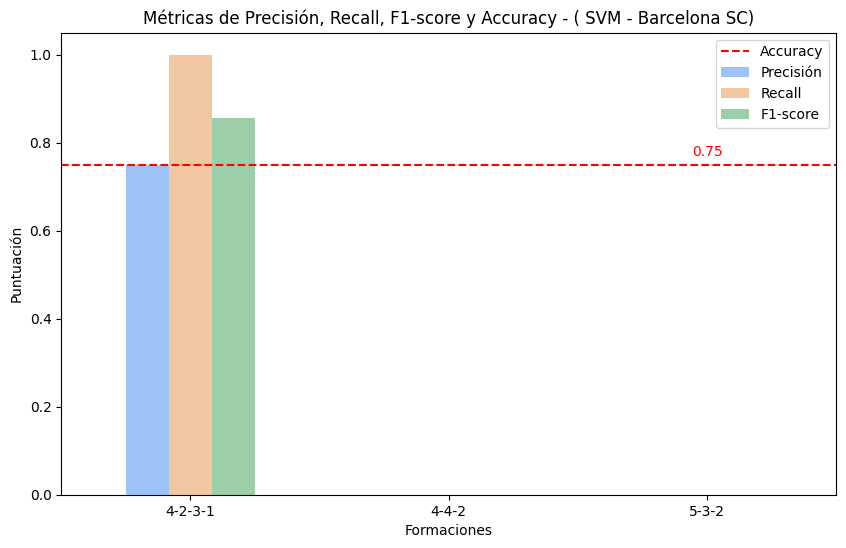

In [65]:
##### Evaluación del Modelo #####
# Generar el reporte de clasificación
report_string = classification_report(val_data[y_variables], y_pred)
labels = re.findall(r'^\s*(\d-\d-\d-\d|\d-\d-\d)', report_string, re.MULTILINE)
print("Labels extraídos:", labels)

# Matriz de confusión
cm = confusion_matrix(val_data[y_variables], y_pred, labels=labels)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Formaciones Predichas", fontsize=8)
plt.ylabel("Formaciones Reales", fontsize=8)
plt.title(f"Matriz de Confusión - ( {modelo} - {Equipos_evaluar})", fontsize=11)
plt.show()

##### Distribución de Formaciones #####
plt.figure(figsize=(8, 5))
sns.histplot(val_data[y_variables], color="blue", label="Formaciones Reales", kde=True, alpha=0.5)
sns.histplot(y_pred, color="red", label="Formaciones Predichas", kde=True, alpha=0.5)
plt.xlabel("Formaciones")
plt.ylabel("Frecuencia")
plt.legend()
plt.title(f"Distribución de Formaciones Predichas vs. Reales - ( {modelo} - {Equipos_evaluar})", fontsize=11)
plt.show()

##### Métricas de Evaluación #####
report = classification_report(val_data[y_variables], y_pred, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-3, :]  # Excluir promedios y accuracy

# Extraer el accuracy
accuracy = report["accuracy"]

# Graficar métricas por clase con colores personalizados
colores_personalizados = ['#85b5f4', '#eeba8a', '#82c294']  # Azul, Naranja, Verde
df_report[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(10, 6),
    color=colores_personalizados,
    alpha=0.8
)

# Agregar el accuracy como una línea horizontal
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Accuracy: {accuracy:.2f}')

# Agregar el valor del accuracy sobre la línea roja
plt.text(
    x=len(df_report) - 1,
    y=accuracy + 0.02,
    s=f'{accuracy:.2f}',
    color='red',
    fontsize=10,
    ha='center'
)

# Personalizar el gráfico
plt.xlabel("Formaciones")
plt.ylabel("Puntuación")
plt.title(f"Métricas de Precisión, Recall, F1-score y Accuracy - ( {modelo} - {Equipos_evaluar})")
plt.legend(["Accuracy", "Precisión", "Recall", "F1-score"])
plt.xticks(rotation=0)
plt.show()


-----------------------------------------------------------------
Predicciones en Victoria: 3 de 4 = 9 puntos
Predicciones en Empate: 3 de 3 = 3 puntos
Predicciones en Derrota: 3 de 5 = 0 puntos
-----------------------------------------------------------------

Resultados para el Partido 1:
Formación real del partido: 4-2-3-1
Formación: 4-2-3-1, Probabilidad: 36.28%
Formación: 4-4-2, Probabilidad: 24.03%
Formación: 4-3-3, Probabilidad: 14.69%
Formación: 3-4-3, Probabilidad: 7.73%
Formación: 4-1-4-1, Probabilidad: 3.85%
Formación: 3-5-2, Probabilidad: 2.56%
Formación: 5-3-2, Probabilidad: 2.54%
Formación: 5-4-1, Probabilidad: 2.29%
Formación: 4-4-1-1, Probabilidad: 1.64%
Formación: 4-5-1, Probabilidad: 1.1%
Formación: 4-2-2-2, Probabilidad: 0.84%
Formación: 4-3-1-2, Probabilidad: 0.64%
Formación: 3-4-1-2, Probabilidad: 0.48%
Formación: 3-1-4-2, Probabilidad: 0.47%
Formación: 4-3-2-1, Probabilidad: 0.32%
Formación: 4-1-3-2, Probabilidad: 0.21%
Formación: 3-4-2-1, Probabilidad: 0.14%
Form

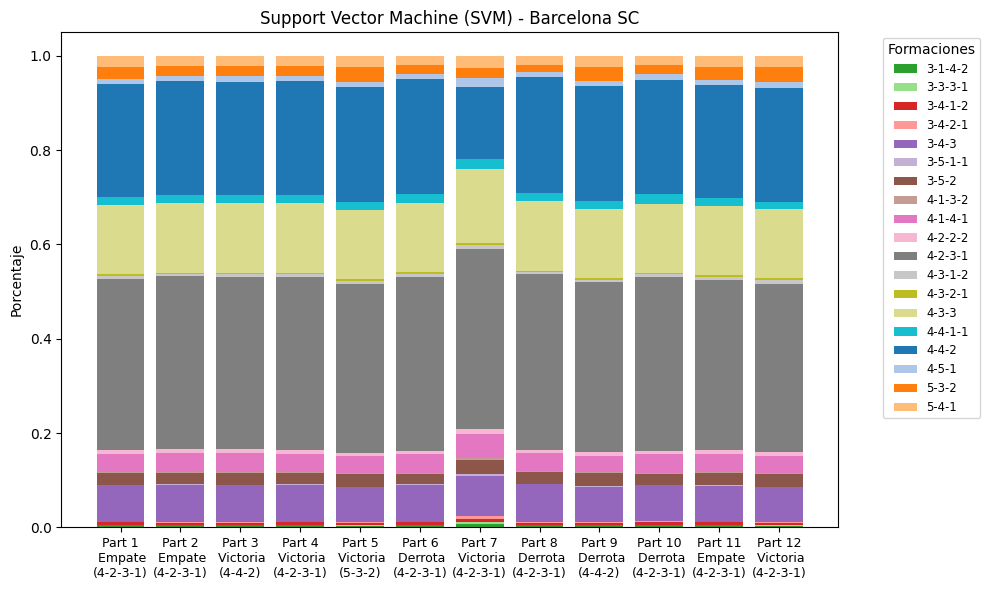

In [66]:
# Análisis de predicciones
resultados = []
for probabilidad in probabilities:
    lista = sorted(
        [(clase, round(prob * 100, 2)) for clase, prob in zip(classes, probabilidad)],
        key=lambda x: x[1], reverse=True
    )
    resultados.append(lista)

# Variables de conteo
puntos_victoria = puntos_empate = puntos_derrota = 0
contador_victoria = contador_empate = contador_derrota = 0
all_results = []

for i, row in enumerate(resultados):
    row_results = row + [(val_data['Formación del oponente'].tolist()[i], 100)]
    row_results.sort(key=lambda x: x[1], reverse=True)

    resultado_real = val_data['Resultado'].tolist()[i]

    if resultado_real == 'D':
        contador_victoria += 1
    elif resultado_real == 'E':
        contador_empate += 1
    else:
        contador_derrota += 1

    if row_results[0][0] == row_results[1][0].replace('vst_', ''):
        if resultado_real == 'D':
            puntos_victoria += 1
        elif resultado_real == 'E':
            puntos_empate += 1
        else:
            puntos_derrota += 1

    all_results.append(row_results)

# Mostrar resultados
print("-----------------------------------------------------------------")
print(f"Predicciones en Victoria: {puntos_victoria} de {contador_victoria} = {puntos_victoria * 3} puntos")
print(f"Predicciones en Empate: {puntos_empate} de {contador_empate} = {puntos_empate * 1} puntos")
print(f"Predicciones en Derrota: {puntos_derrota} de {contador_derrota} = {puntos_derrota * 0} puntos")
print("-----------------------------------------------------------------")

for i, row_results in enumerate(all_results):
    print(f"\nResultados para el Partido {i + 1}:")
    for formation, percentage in row_results:
        if percentage == 100:
            print(f"Formación real del partido: {formation}")
        else:
            print(f"Formación: {formation.replace('vst_', '')}, Probabilidad: {percentage}%")

print("-----------------------------------------------------------------")
# Gráfico de probabilidades por formación

clases = classes
probabilidades = probabilities

# Simulación de datos
resultados = val_data['Resultado'].map({'V': 'Victoria', 'E': 'Empate', 'D': 'Derrota'}).tolist()
formaciones = val_data['Formación del oponente'].tolist()

# Configuración del gráfico
num_muestras = len(resultados)
indices = np.arange(num_muestras)

# Paleta de colores "tab20" (20 colores distintos)
paleta_colores = sns.color_palette("tab20", len(clases))

# Rotar la paleta de colores para iniciar con un color diferente
paleta_colores = paleta_colores[4:] + paleta_colores[:4]  # Esto moverá los primeros 5 colores al final

# Si tienes más de 20 clases, puedes combinar paletas o generar colores aleatorios:
if len(clases) > 20:
    paleta_colores = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", len(clases) - 20)
    # O, para colores aleatorios:
    # paleta_colores = sns.color_palette("hls", len(clases))


# Crear la figura
plt.figure(figsize=(10, 6))

# Agregar barras apiladas
bottom = np.zeros(num_muestras)
for i in range(len(clases)):
    plt.bar(indices, probabilidades[:, i], label=f'{clases[i]}', bottom=bottom, color=paleta_colores[i])
    bottom += probabilidades[:, i]


# Personalizar etiquetas del eje X (sin cambios)
etiquetas_x = [f'Part {i+1}\n {r}\n({f})' for i, (r, f) in enumerate(zip(resultados, formaciones))]
plt.xticks(indices, etiquetas_x, rotation=0, fontsize=9)

# Etiquetas y diseño
plt.ylabel('Porcentaje')
plt.title(f'Support Vector Machine (SVM) - {Equipos_evaluar}')

# 3. Mejoras en la leyenda (opcional)
plt.legend(title='Formaciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small') # Ajusta fontsize si es necesario

# 4. Ajustar el espaciado entre barras (opcional)
plt.subplots_adjust(bottom=0.2) # Ajusta el valor según sea necesario

plt.tight_layout()
nombre_archivo = f'SVM_{Equipos_evaluar}.png'
plt.savefig(nombre_archivo)

# Mostrar gráfico
plt.show()

## **MODELO DE REGRESION LOGISTICA MULTINOMIAL**

In [67]:
# Configuración inicial
data_RL = df.copy()
modelo = 'Regresión Logística'

# Definición de variables dependientes e independientes
y_variables = "Formación del oponente"


x_variables = [
    "P. Victoria",
    "P. Empate",
    "P. Perdida",
    "diferencia_altitud",
    "Altura",
]

# Filtrado de datos para validación y entrenamiento
val_data = data_RL[ (data_RL['Fecha'].dt.year == 2024) &(data_RL['clasificacion_del_partido'] == 'Altura vs Costa')& (data_RL['Adversario'] ==Equipos_evaluar)]
test_data = data_RL[data_RL['Fecha'].dt.year == 2024& (data_RL['Resultado'] == 'D') | (data_RL['Resultado'] == 'E')]
train_data = data_RL[data_RL['Fecha'].dt.year != 2024& (data_RL['Resultado'] == 'D') | (data_RL['Resultado'] == 'E')]

# Asignar las variables de entrada y salida
X_train = train_data[x_variables]
y_train = train_data[y_variables]

X_test = test_data[x_variables]
y_test = test_data[y_variables]


# Crear el modelo de regresión logística multinomial
model_RL = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

model_RL.fit(X_train, y_train)

# Hacer predicciones
y_pred = model_RL.predict(val_data[x_variables].values)

accuracy = accuracy_score(val_data[y_variables].values, y_pred)  # Calculate accuracy
recall = recall_score(val_data[y_variables].values, y_pred, average='weighted')
precision = precision_score(val_data[y_variables].values, y_pred, average='weighted')
f1_score = f1_score(val_data[y_variables].values, y_pred, average='weighted')
print(f"Precisión del modelo: {accuracy}")
print(f"Recall del modelo: {recall}")
print(f"Precisión del modelo: {precision}")
print(f"F1-score del modelo: {f1_score}")

classification_rep = classification_report(val_data[y_variables].values, y_pred)
print("Reporte de clasificación:")
print(classification_rep)

Precisión del modelo: 0.75
Recall del modelo: 0.75
Precisión del modelo: 0.5625
F1-score del modelo: 0.6428571428571428
Reporte de clasificación:
              precision    recall  f1-score   support

     4-2-3-1       0.75      1.00      0.86         9
       4-4-2       0.00      0.00      0.00         2
       5-3-2       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.25      0.33      0.29        12
weighted avg       0.56      0.75      0.64        12



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     4-2-3-1       0.75      1.00      0.86         9
       4-4-2       0.00      0.00      0.00         2
       5-3-2       0.00      0.00      0.00         1

    accuracy                           0.75        12
   macro avg       0.25      0.33      0.29        12
weighted avg       0.56      0.75      0.64        12

Labels extraídos: ['4-2-3-1', '4-4-2', '5-3-2']


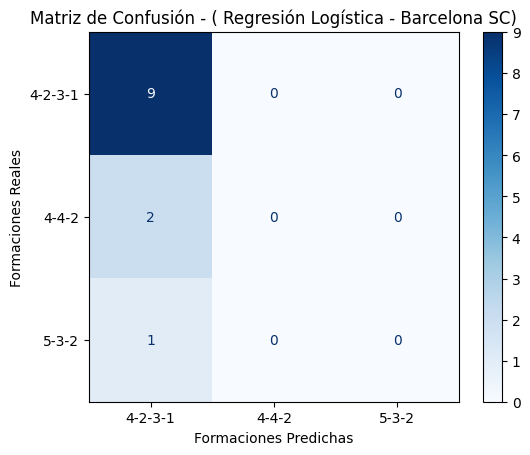

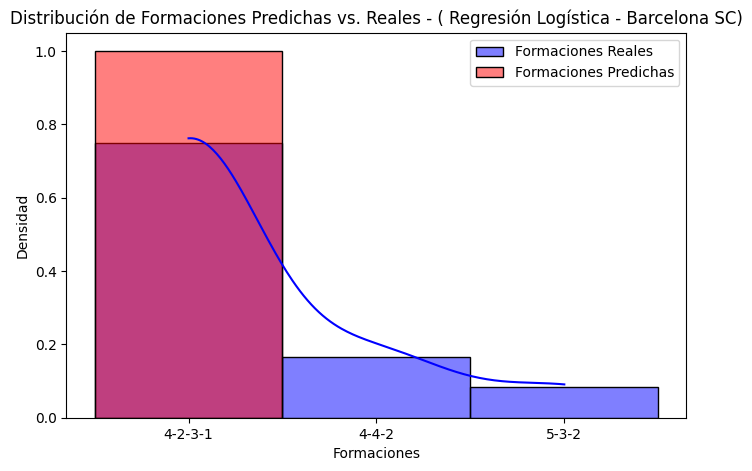

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


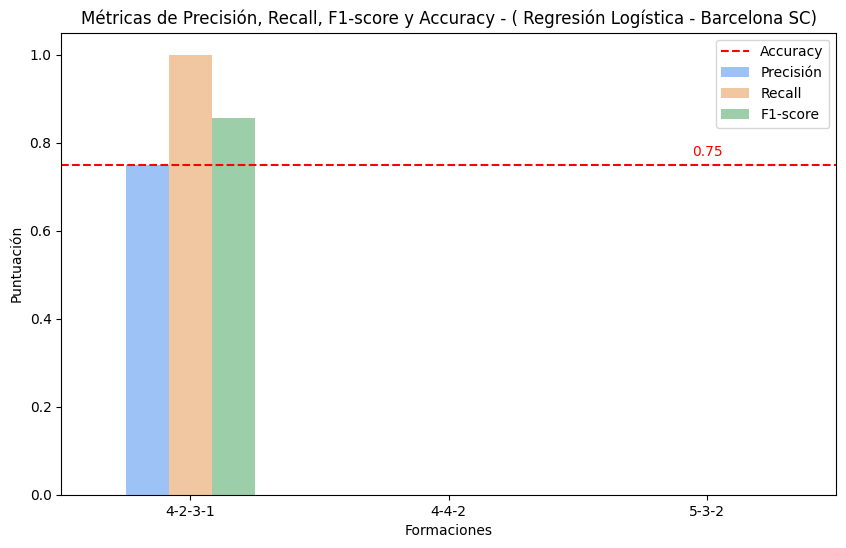

In [68]:
# Generar reporte de clasificación
report_string = classification_report(val_data[y_variables], y_pred)
print(report_string)

# Extraer etiquetas de clase
labels = sorted(val_data[y_variables].unique())  # Obtiene las formaciones únicas ordenadas
print("Labels extraídos:", labels)

# Calcular la matriz de confusión
cm = confusion_matrix(val_data[y_variables], y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Formaciones Predichas", fontsize=10)
plt.ylabel("Formaciones Reales", fontsize=10)
plt.title(f"Matriz de Confusión - ( {modelo} - {Equipos_evaluar})", fontsize=12)
plt.show()

# Visualizar la distribución de formaciones
plt.figure(figsize=(8, 5))
sns.histplot(val_data[y_variables], color="blue", label="Formaciones Reales", kde=True, stat="density", alpha=0.5)
sns.histplot(y_pred, color="red", label="Formaciones Predichas", kde=True, stat="density", alpha=0.5)
plt.xlabel("Formaciones", fontsize=10)
plt.ylabel("Densidad", fontsize=10)
plt.legend()
plt.title(f"Distribución de Formaciones Predichas vs. Reales - ( {modelo} - {Equipos_evaluar})", fontsize=12)
plt.show()

# Reporte en formato DataFrame
report = classification_report(val_data[y_variables], y_pred, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-3, :]  # Excluir promedios y accuracy

# Extraer el accuracy
accuracy = report["accuracy"]

# Graficar métricas por clase con colores personalizados
colores_personalizados = ['#85b5f4', '#eeba8a', '#82c294']  # Azul, Naranja, Verde
df_report[['precision', 'recall', 'f1-score']].plot(
    kind='bar',
    figsize=(10, 6),
    color=colores_personalizados,
    alpha=0.8
)

# Agregar el accuracy como una línea horizontal
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Accuracy: {accuracy:.2f}')

# Agregar el valor del accuracy sobre la línea roja
plt.text(
    x=len(df_report) - 1,  # Última barra
    y=accuracy + 0.02,  # Posición en el eje y
    s=f'{accuracy:.2f}',
    color='red',
    fontsize=10,
    ha='center'
)

# Personalizar el gráfico
plt.xlabel("Formaciones", fontsize=10)
plt.ylabel("Puntuación", fontsize=10)
plt.title(f"Métricas de Precisión, Recall, F1-score y Accuracy - ( {modelo} - {Equipos_evaluar})", fontsize=12)
plt.legend(["Accuracy", "Precisión", "Recall", "F1-score"])
plt.xticks(rotation=0)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


-----------------------------------------------------------------
Predicciones en Victoria: 3 de 4 = 9 puntos
Predicciones en Empate: 3 de 3 = 3 puntos
Predicciones en Derrota: 3 de 5 = 0 puntos
-----------------------------------------------------------------

Resultados para el Partido 1:
Formación real del partido: 4-2-3-1
Formación: 4-2-3-1, Probabilidad: 43.95%
Formación: 4-4-2, Probabilidad: 26.33%
Formación: 4-3-3, Probabilidad: 11.24%
Formación: 3-4-3, Probabilidad: 4.1%
Formación: 4-1-4-1, Probabilidad: 2.97%
Formación: 5-3-2, Probabilidad: 2.17%
Formación: 3-5-2, Probabilidad: 1.98%
Formación: 5-4-1, Probabilidad: 1.7%
Formación: 4-4-1-1, Probabilidad: 1.69%
Formación: 4-5-1, Probabilidad: 0.87%
Formación: 4-2-2-2, Probabilidad: 0.71%
Formación: 3-4-1-2, Probabilidad: 0.65%
Formación: 4-3-1-2, Probabilidad: 0.59%
Formación: 3-1-4-2, Probabilidad: 0.38%
Formación: 4-3-2-1, Probabilidad: 0.32%
Formación: 4-1-3-2, Probabilidad: 0.13%
Formación: 3-4-2-1, Probabilidad: 0.1%
Formac

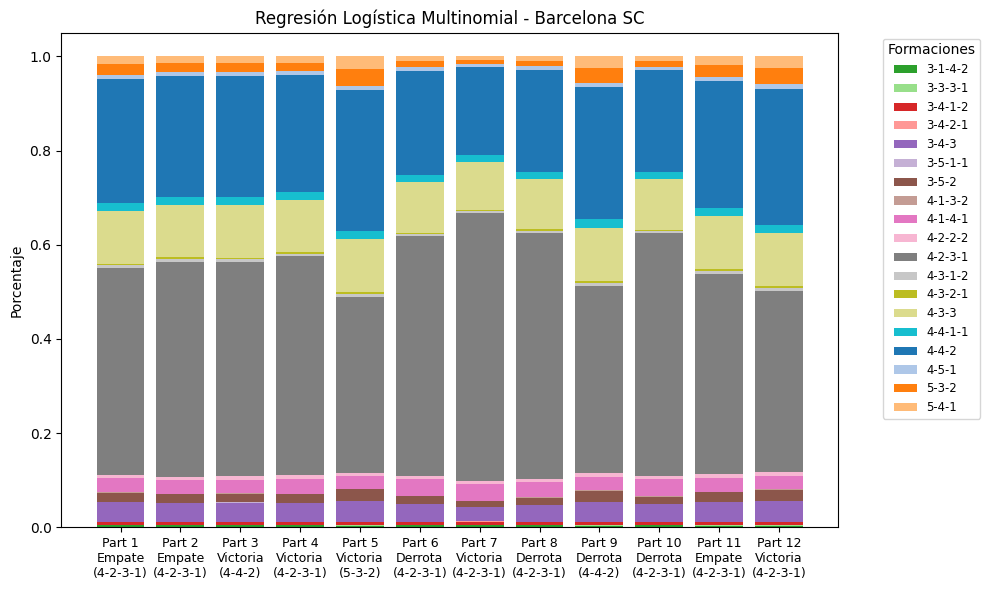

In [69]:
# Obtener probabilidades y clases del modelo
probabilities = model_RL.predict_proba(val_data[x_variables])
classes = model_RL.classes_

# Procesar resultados: ordenar por probabilidad descendente y redondear a 2 decimales
resultados = []
for probabilidad in probabilities:
    lista = []
    for clase, prob in zip(classes, probabilidad):
        lista.append((clase, round(prob*100, 2)))
    lista.sort(key=lambda x: x[1], reverse=True)  # Ordenar por probabilidad
    resultados.append(lista)

# Inicializar variables para el análisis de resultados
all_results = []
puntos_victoria = puntos_empate = puntos_derrota = 0
contador_victoria = contador_empate = contador_derrota = 0

# Procesar cada partido
for i, row in enumerate(resultados):
    row_results = []
    # Agregar formaciones con sus probabilidades
    for formation, prob in row:
        row_results.append((formation, round(prob, 2)))

    # Agregar formación real del oponente (con 100% para destacar)
    row_results.append((val_data['Formación del oponente'].tolist()[i], 100))
    row_results.sort(key=lambda x: x[1], reverse=True)

    # Contar resultados reales
    resultado_real = val_data['Resultado'].tolist()[i]
    if resultado_real == 'D':
        contador_victoria += 1
    elif resultado_real == 'E':
        contador_empate += 1
    else:
        contador_derrota += 1

    # Verificar si la predicción coincide con la formación real
    if row_results[0][0] == row_results[1][0].replace('vst_', ''):
        if resultado_real == 'D':
            puntos_victoria += 1
        elif resultado_real == 'E':
            puntos_empate += 1
        else:
            puntos_derrota += 1

    all_results.append(row_results)

# Mostrar resumen de predicciones
print("-----------------------------------------------------------------")
print(f"Predicciones en Victoria: {puntos_victoria} de {contador_victoria} = {(puntos_victoria*3)} puntos")
print(f"Predicciones en Empate: {puntos_empate} de {contador_empate} = {(puntos_empate*1)} puntos")
print(f"Predicciones en Derrota: {puntos_derrota} de {contador_derrota} = {(puntos_derrota*0)} puntos")
print("-----------------------------------------------------------------")

# Mostrar resultados detallados por partido
for i, row_results in enumerate(all_results):
    print(f"\nResultados para el Partido {i + 1}:")
    for formation, percentage in row_results:
        if percentage == 100:
            print(f"Formación real del partido: {formation}")
        else:
            formation = formation.replace('vst_', '')
            print(f"Formación: {formation}, Probabilidad: {percentage}%")
print("-----------------------------------------------------------------")


# Obtener probabilidades y clases
probabilidades = model_RL.predict_proba(val_data[x_variables].values)
clases = model_RL.classes_

# Preparar datos para el gráfico
resultados = val_data['Resultado'].map({'V': 'Victoria', 'E': 'Empate', 'D': 'Derrota'}).tolist()
formaciones = val_data['Formación del oponente'].tolist()
num_muestras = len(resultados)
indices = np.arange(num_muestras)

# Configurar paleta de colores
if len(clases) <= 20:
    paleta_colores = sns.color_palette("tab20", len(clases))
    paleta_colores = paleta_colores[4:] + paleta_colores[:4]  # Rotar colores
else:
    paleta_colores = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", len(clases) - 20)

# Crear gráfico
plt.figure(figsize=(10, 6))

# Agregar barras apiladas
bottom = np.zeros(num_muestras)
for i in range(len(clases)):
    plt.bar(indices, probabilidades[:, i], label=f'{clases[i]}', bottom=bottom, color=paleta_colores[i])
    bottom += probabilidades[:, i]

# Configurar etiquetas y diseño
etiquetas_x = [f'Part {i+1}\n{r}\n({f})' for i, (r, f) in enumerate(zip(resultados, formaciones))]
plt.xticks(indices, etiquetas_x, rotation=0, fontsize=9)
plt.ylabel('Porcentaje')
plt.title(f'Regresión Logística Multinomial - {Equipos_evaluar}')

# Añadir leyenda y ajustar diseño
plt.legend(title='Formaciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()

# Guardar y mostrar gráfico
nombre_archivo = f'RLM_{Equipos_evaluar}.png'
plt.savefig(nombre_archivo)
plt.show()